# Lab1 使用FIR滤波器分离鸟类声音
# 01: DSP & Python
> 该实验改编自Xilinx的[DSP-PYNQ](https://github.com/Xilinx/DSP-PYNQ)，使用Xilinx Vitis HLS生成的FIR IP来进行音频滤波操作

## 检查我们的信号

`birds.wav`是一个音频文件，包含两种鸟类的声音，其由Stuart Fisher录制，可以在[此处](https://www.xeno-canto.org/28039)获取。


In [19]:
from IPython.display import Audio
Audio("birds.wav")

播放上面的音频，我们可以发现两种鸟类的叫声混杂在一起：
- 频率较低、鸣叫时长较短的鸟类是麻鹬
- 频率较高、鸣叫时长较长的鸟类是麻雀

我们希望通过数字信号处理的方法将两种鸟类的分离开来，并使用硬件函数为其加速。

<div style='max-width: 1005px;'>
<div style='width:40%; float:left; text-align:center;'>
    <img src="./curlew.jpg"/>
    <b>Curlew</b> <br/>Photo by Vedant Raju Kasambe <br/> <a href="https://creativecommons.org/licenses/by-sa/4.0/deed.en">Creative Commons Attribution-Share Alike 4.0</a>
</div>
<div style='width:40%; float:right; text-align:center;'>
    <img src="./chaffinch.jpg"/>
    <b>Chaffinch</b> <br/>Photo by Charles J Sharp <br/> <a href="https://creativecommons.org/licenses/by/3.0/deed.en">Creative Commons Attribution 3.0</a>
</div>
</div>

### 读入信号
让我们使用SciPy的`wavfile`模块完成信号的读入，fs为采样频率，aud_in为原始数据。

In [20]:
from scipy.io import wavfile

fs, aud_in = wavfile.read("./birds.wav")

我们查看下采样频率大小，原始数据的类型、长度和格式等信息。

采样频率为标准的44.1KHz，数据是以int16格式的numpy.ndarray保存的，共有554112个采样点。

In [21]:
print(fs)
print(type(aud_in))
print(len(aud_in))
print(aud_in.dtype)
print(aud_in[10000:10009])

44100
<class 'numpy.ndarray'>
554112
int16
[-37  25 128 210 183 202 278 310 300]


### 绘制频谱图
为了便于观察，我们可以创建一些交互式的绘图组件来帮助数据可视化。

在Notebook中绘制数据的频谱图是一个很好的选择，这有助于观察信号随时间的频率变化。

首先，我们禁止来自scipy的FutureWarnings，这些警告是针对Python包中将来将被弃用的特性的。 

In [22]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

我们采用plotly的一些底层API来绘制图形，使用scipy的一些模块来获得频谱数据。

图形的绘制会需要一定的时间。

In [23]:
import plotly.graph_objs as go
import plotly.offline as py
from scipy.signal import spectrogram, decimate
import numpy as np

def plot_spectrogram(samples, fs, decimation_factor=3, max_heat=50, mode='2D'):
    
    # Optionally decimate input
    if decimation_factor > 1:
        samples_dec = decimate(samples, decimation_factor, zero_phase=True)
        fs_dec = int(fs / decimation_factor)
    else:
        samples_dec = samples
        fs_dec = fs

    # Calculate spectrogram (an array of FFTs from small windows of our signal)
    f_label, t_label, spec_data = spectrogram(
        samples_dec, fs=fs_dec, mode="magnitude"
    )
    
    # Create layout for the plot
    layout = go.Layout(
        height=500,
        # Axis titles
        xaxis=dict(title='Time (s)'),
        yaxis=dict(title='Frequency (Hz)'),
        scene=dict(
            xaxis=dict(title='Time (s)'),
            yaxis=dict(title='Frequency (Hz)'),
            zaxis=dict(title='Amplitude')
        )
    )
    
    # Create trace for the plot
    if mode == '2D':
        trace = go.Heatmap(
            z=np.clip(spec_data, 0, max_heat),
            y=f_label,
            x=t_label
        )
    else:
        trace = go.Surface(
            z=spec_data,
            y=f_label,
            x=t_label
        )
    
    # Plot the spectrogram
    fig = go.Figure(data=[trace], layout=layout)
    py.iplot(fig)

plot_spectrogram(aud_in, fs, mode='2D')


观察上图，我们可以明显地区分开两种鸟类的声音——麻鹬声位于1.2-2.6kHz之间而麻雀声位于3-5kHz之间。

下面，我们可以先在Python中设计滤波器将**麻鹬声**提取出来，即滤掉3-5kHz之间的麻雀声。

---------

## FIR 滤波器

我们可以使用SciPy中的信号处理模块来设计FIR滤波器的参数与实现滤波功能：

- `firwin` 可用于计算满足设计要求的滤波器参数
- `freqz` 可用于计算滤波器的频率响应

为了过滤出频率更低的麻鹬声，需要一个低通滤波器来抑制2.6kHz以上的信号，我们预留些余量，将截止频率设置为2.8kHz。

In [15]:
from scipy.signal import freqz, firwin

nyq = fs / 2.0
taps = 99

# Design high-pass filter with cut-off at 2.8 kHz
hpf_coeffs = firwin(taps, 2800/nyq)

freqs, resp = freqz(hpf_coeffs, 1)

sample_freqs = np.linspace(0, nyq, len(np.abs(resp)))

我们可以对频率响应曲线进行可视化，帮助我们更好地进行滤波器设计。

Text(0, 0.5, 'Normalised amplitude')

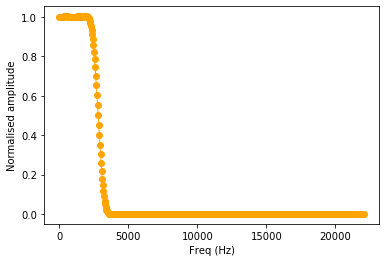

In [16]:
import matplotlib.pyplot as plt

plt.plot(sample_freqs, abs(resp), linewidth=1, color="orange", marker="o")
plt.xlabel("Freq (Hz)")
plt.ylabel("Normalised amplitude")

滤波器共有99个参数，以float64的格式保存。

In [17]:
len(hpf_coeffs)

99

查看部分参数。

In [18]:
hpf_coeffs[0:9]

array([ 3.34510908e-04,  1.58438145e-04, -5.65708670e-05, -2.93230025e-04,
       -5.26351525e-04, -7.21303131e-04, -8.35689727e-04, -8.25205065e-04,
       -6.53401212e-04])

# 02:DSP & HW

为了便于硬件实现，我们将原始的float64格式转化为int32，将其进行简单的量化。

In [47]:
hpf_coeffs_quant = np.array(hpf_coeffs)
hpf_coeffs_hw = np.int32(hpf_coeffs_quant/np.max(abs(hpf_coeffs_quant)) * 2**15 - 1)

最终将写入到IP中的系数如下。

In [48]:
hpf_coeffs_hw

array([   85,    39,   -15,   -76,  -136,  -186,  -216,  -213,  -169,
         -79,    52,   212,   376,   512,   584,   560,   421,   165,
        -186,  -588,  -974, -1265, -1384, -1272,  -900,  -283,   513,
        1381,  2174,  2732,  2907,  2589,  1738,   396, -1297, -3119,
       -4776, -5942, -6302, -5597, -3665,  -482,  3829,  8997, 14622,
       20218, 25269, 29288, 31874, 32767, 31874, 29288, 25269, 20218,
       14622,  8997,  3829,  -482, -3665, -5597, -6302, -5942, -4776,
       -3119, -1297,   396,  1738,  2589,  2907,  2732,  2174,  1381,
         513,  -283,  -900, -1272, -1384, -1265,  -974,  -588,  -186,
         165,   421,   560,   584,   512,   376,   212,    52,   -79,
        -169,  -213,  -216,  -186,  -136,   -76,   -15,    39,    85])

### 加载Overlay

Overlay模块封装了ARM CPU与FPGA的PL部分进行交互的接口。

- 我们可以通过简单的`Overlay()`方法将刚才生成的硬件设计加载到PL上
- 通过`overlay.fir_wrap_0`语句，我们可以通过访问的Python对象的形式来与IP交互

In [49]:
from pynq import Overlay
overlay = Overlay("./fir.bit")
fir = overlay.fir_wrap_0

### 分配内存供IP使用
`pynq.allocate`函数用于为PL中的IP分配可以使用的内存空间。
- 在PL中的IP访问DRAM之前，必须为其保留一些内存供IP使用，分配大小与地址
- 我们分别为输入、输出和权重三个部分分配内存，数据类型为int32
- `pynq.allocate`会分配物理上的连续内存，并返回一个`pynq.Buffer`表示已经分配缓冲区的对象

In [50]:
from pynq import allocate
sample_len = len(aud_in)
input_buffer = allocate(shape=(sample_len,), dtype='i4')
output_buffer = allocate(shape=(sample_len,), dtype='i4')
coef_buffer = allocate(shape=(99,), dtype='i4')

将python的本地内存中的音频数据和系数数据，复制到我们刚分配的内存中。

In [51]:
np.copyto(input_buffer, np.int32(aud_in))
np.copyto(coef_buffer, hpf_coeffs_hw)

我们可以看到，缓冲区本质也是numpy数组，但是提供了一些物理地址属性。

In [52]:
input_buffer[10000:10009]

PynqBuffer([-37,  25, 128, 210, 183, 202, 278, 310, 300])

In [53]:
coef_buffer[0:9]

PynqBuffer([  85,   39,  -15,  -76, -136, -186, -216, -213, -169])

In [54]:
coef_buffer.physical_address

377790464

### 配置IP

我们可以直接使用IP的`write`方法，将刚分配的内存空间的地址写入到IP对应位置上

对于数据长度，我们可以直接在对应寄存器写入值。

In [55]:
fir.s_axi_control.write(0x1c,input_buffer.physical_address)
fir.s_axi_control.write(0x10,output_buffer.physical_address)
fir.s_axi_control.write(0x28,coef_buffer.physical_address)
fir.s_axi_CTRL.write(0x10, sample_len)

### 启动IP

控制信号位于0x00地址，我们可以对其进行写入与读取来控制IP启动、监听是否完成。

In [56]:
import time

fir.s_axi_CTRL.write(0x00, 0x01)
start_time = time.time()
while True:
    reg = fir.s_axi_CTRL.read(0x00)
    if reg != 1:
        break
end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.08661985397338867s


结果已经被写入到了`output_buffer`中，我们可以进行查看

In [57]:
output_buffer[10000:10009]

PynqBuffer([119718393, 132916501, 144469788, 152624086, 155968934,
            153635840, 145354823, 131477334, 112938378])

### 可视化结果

仍然使用上述绘图组件，我们对硬件函数的结果进行可视化

- 可以看到，相较于原信号，低频部分都被较好的去除了
- 由于对参数进行了量化，值普遍偏大

In [ ]:
plot_spectrogram(output_buffer, fs, mode='2D', max_heat=np.max(abs(output_buffer)))

我们可以再对输出结果进行缩放，将结果写入到音频`hpf_hw.wav`中并进行试听，可以发现麻雀的声音已经被成功去除了。

In [ ]:
from IPython.display import Audio

scaled = np.int16(output_buffer/np.max(abs(output_buffer)) * 2**15 - 1)
wavfile.write('hpf_hw.wav', fs, scaled)
Audio('hpf_hw.wav')